In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
log_df = pd.read_pickle("laguna_seca_lap_df.pkl")

Tire Temperature: This one seems pretty simple if the underlying model is ~right
- Inputs:
    - Current Temperature: measured with contactless IR sensor
    - Tire Forces: 
        - Down Force:
            - Car weight: Measure on a scale and record
            - Aerodynamic downforce: need to find a way to either measure this based on ride height OR model it based on ability to turn?
        - Acceleration/Braking Force:
            - Measure from IMU and record on open log
        - Cornering Force / Perpendicular Force:
            - Measure from IMU and record on open log
    - Car Speed:
        - Measured from IMU and record on Open Log
    - Ambient Temperature:
        - Measure and record manually
    - Ground Temperature: 
        - Measure and record manually
- Outputs:
    - New Temperature: measured with contactless IR sensor

Implied todos:
1. Get a few digital thermometers that record the air temp, ground temp, and tire temp
2. Time synch the ESC data log and the openlog

In [2]:
from Tire import Tire

tire = Tire()
tire.calc_values()
tire.print()

TireParams: Diameter:  0.099  m
TireParams: Radius:  0.0495  m
TireParams: Radius:  0.0495  m
TireParams: Tread Depth:  0.011000000000000003  m
TireParams: Length:  0.042  m
TireParams: Surface Area:  0.013062742253626362  m^2
TireParams: Contact Patch:  4.620000000000002e-05  m^2
TireParams: Temp:  21.12  C
TireParams: Max Temp:  54.4  C
TireParams: Mass:  70.24852500839064  g
TireParams: Specific Heat Coeff:  1.88  J/(g * deg C)
TireParams: Specific Heat Mass:  132.0672270157744  J/(deg C)
TireParams: H Convection:  200.0
TireParams: H Conduction:  1.0


In [3]:
#https://pymoo.org/getting_started/part_3.html
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.pso import PSO # particle swarm
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize



class TireTemperatureOptmization(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=1,
                         n_ieq_constr=0,
                         xl=np.array([100, 0, 100]),
                         xu=np.array([500.0,10, 200]))

    def _evaluate(self, x, out, *args, **kwargs):
        timestep = 0.01
        tire_temp = log_df["Tire Temp (C)"].iloc[0]
        ground_temp = 31.11
        ambient_temp = 21.12
        err = 0.0
        # temps = []
        for i in range(len(log_df["Tire Temp (C)"])):
            speed = log_df["Speed (m/s)"].iloc[i]
            heat_generated = np.sum([log_df["Down Force (N)"].iloc[i] + 8.0*9.81,
                                        log_df["Drag Force (N)"].iloc[i] + log_df["Acceleration (m/s^2)"].iloc[i],
                                        log_df["Perp Force (N)"].iloc[i]]) * tire.tire_hysteresis_coeff * speed
            heat_expelled_convection = x[0] * tire.surface_area * (tire_temp - ambient_temp) # rate of heat expulsion - W - J/
            heat_expelled_conduction = x[1] * tire.contact_patch * (tire_temp - ground_temp) # rate of heat expulsion - W - J/s
            heat_diff = heat_generated - (heat_expelled_convection + heat_expelled_conduction)
            tire_temp = (heat_diff * timestep) / x[2] + tire_temp # deg C
            # temps.append(tire_temp)
            err += abs(log_df["Tire Temp (C)"].iloc[i] - tire_temp)
        
        f1 = err# / len(log_df["Motor Temp (C)"])
        out["F"] = [f1]
        out["G"] = []


problem = TireTemperatureOptmization()

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

alg2 = PSO() # PSO can't be used on multiobjective optimization


termination = get_termination("n_gen", 40)

res = minimize(problem,
               alg2,#algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

x = res.X
F = res.F

r_x = np.array([tire.h_convection,
              tire.h_conduction,
              tire.specific_heat_mass
              ])

print("F: ", F)
print("Recorded X: ", r_x)
print("Estimate X: ", x)
print("Diff: ", abs(x - r_x))

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       25 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  3.837060E+04 |  7.311124E+03
     2 |       50 |  0.16745 |       3 |  0.5075 |  2.00000 |  2.01938 |  2.870154E+04 |  2.654057E+03
     3 |       75 |  0.05991 |       3 |  0.4379 |  1.99049 |  2.02788 |  1.760294E+04 |  2.654047E+03
     4 |      100 | -1.7E-02 |       3 |  0.3893 |  1.98179 |  2.04479 |  9.554525E+03 |  1.008468E+03
     5 |      125 | -2.7E-02 |       3 |  0.3832 |  1.96910 |  2.05015 |  6.129880E+03 |  1.008468E+03
     6 |      150 | -2.2E-02 |       3 |  0.3866 |  1.96046 |  2.06420 |  4.750562E+03 |  6.817066E+02
     7 |      175 | -2.6E-02 |       3 |  0.3840 |  1.94963 |  2.07966 |  3.383640E+03 |  6.817066E+02
     8 |      200 | -2.7E-02 |       3 |  0.3830 |  1.93666 |  2.08935 |  3.079191E+03 |  6.817066E+02
     9 |      225 | -1.8E-02 |       3 |  0.3891 |  1.92516 |  2.09476 | 

Recorded X:  [200.           1.         132.06722702]
Estimate X:  [199.99437275   8.27890586 132.07413734]
Diff:  [5.62724672e-03 7.27890586e+00 6.91032596e-03]


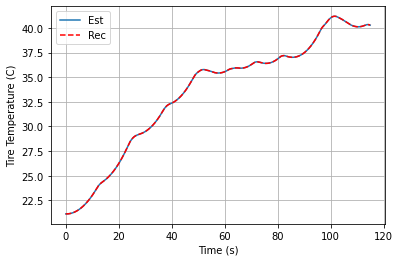

In [4]:
r_x = np.array([tire.h_convection,
              tire.h_conduction,
              tire.specific_heat_mass
              ])

print("Recorded X: ", r_x)
print("Estimate X: ", x)
print("Diff: ", abs(x - r_x))

timestep = 0.01
tire_temp = log_df["Tire Temp (C)"].iloc[0]
ground_temp = 31.11
ambient_temp = 21.12
err = 0.0
temps = []
for i in range(len(log_df["Tire Temp (C)"])):
    speed = log_df["Speed (m/s)"].iloc[i]
    heat_generated = np.sum([log_df["Down Force (N)"].iloc[i] + 8.0*9.81,
                                log_df["Drag Force (N)"].iloc[i] + log_df["Acceleration (m/s^2)"].iloc[i],
                                log_df["Perp Force (N)"].iloc[i]]) * tire.tire_hysteresis_coeff * speed
    heat_expelled_convection = x[0] * tire.surface_area * (tire_temp - ambient_temp) # rate of heat expulsion - W - J/
    heat_expelled_conduction = x[1] * tire.contact_patch * (tire_temp - ground_temp) # rate of heat expulsion - W - J/s
    heat_diff = heat_generated - (heat_expelled_convection + heat_expelled_conduction)
    tire_temp = (heat_diff * timestep) / x[2] + tire_temp # deg C
    temps.append(tire_temp)
    
plt.plot(log_df['Time (s)'], temps, label="Est")
plt.plot(log_df['Time (s)'], log_df["Tire Temp (C)"], 'r--', label="Rec")
plt.ylabel("Tire Temperature (C)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()
